In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.transforms import transforms
import pathlib
import nibabel as nib
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [3]:
### WE MOETEN NOG DROPOUT IMPLEMENTEREN

In [4]:
# Train_voor = []
# Train_na = []

# path = pathlib.Path('processed').parent
# for timestamp in ["-001h", "024h"]:
#     for mouse in ["M03", "M04", "M05", "M06", "M07"]:
#         if timestamp == "-001h":
#             path_ct = path / f"processed/{mouse}_{timestamp}_CT280.img"
#             Train_voor.append(nib.load(path_ct).get_fdata())
#         else: 
#             path_ct = path / f"processed/{mouse}_{timestamp}_CT280.img"
#             Train_na.append(nib.load(path_ct).get_fdata())           

# Train_Data_001h = []
# Train_Data_024h = []
# for mouse in Train_voor:
#     for slice in mouse:
#         Train_Data_001h.append(slice)

# for mouse in Train_na:
#     for slice in mouse:
#         Train_Data_024h.append(slice)


# Test_Data_001h = []
# Test_Data_024h = []

# for timestamp in ["-001h", "024h"]:
#     mouse = "M08"
#     path_ct = path / f"processed/{mouse}_{timestamp}_CT280.img"
#     ct = nib.load(path_ct).get_fdata()
#     for slice in ct:
#         if timestamp == "-001h":
#             Test_Data_001h.append(slice)
#         else:
#             Test_Data_024h.append(slice)

# #Train_Data_001h (770 slices) 5 muisjes
# #Train_Data_024h (770 slices)
# #Test_Data_001h  (154 slices)
# #Test_Data_024h  (154 slices)


In [5]:
Train_voor = []
Train_na = []

path = pathlib.Path('processed').parent
for timestamp in ["-001h", "024h"]:
     for mouse in ["M03", "M04", "M05", "M06", "M07"]:
         if timestamp == "-001h":
             path_ct = path / f"processed/{mouse}_{timestamp}_CT280.img"
             Train_voor.append(nib.load(path_ct).get_fdata())
         else: 
             path_ct = path / f"processed/{mouse}_{timestamp}_CT280.img"
             Train_na.append(nib.load(path_ct).get_fdata())           


Train_Data_001h = []
Train_Data_024h = []

for mouse in Train_voor:
    for i in range(mouse.shape[-1]):
        Train_Data_001h.append(mouse[:,:,i])


for mouse in Train_na:
    for i in range(mouse.shape[-1]):
         Train_Data_024h.append(mouse[:,:,i])


Test_Data_001h = []
Test_Data_024h = []

for timestamp in ["-001h", "024h"]:
     mouse = "M08"
     path_ct = path / f"processed/{mouse}_{timestamp}_CT280.img"
     ct = nib.load(path_ct).get_fdata()
     for i in range(ct.shape[-1]):
        if timestamp == "-001h":
            Test_Data_001h.append(ct[:,:,i])
        else:
            Test_Data_024h.append(ct[:,:,i])

#Train_Data_001h (1210 slices)
#Train_Data_024h (1210 slices)
#Test_Data_001h  (242 slices)
#Test_Data_024h  (242 slices)


<class 'numpy.memmap'>


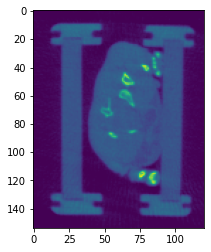

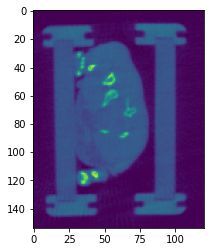

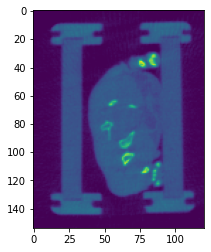

In [38]:
afb = Test_Data_001h[50]
print(type(afb))
plt.imshow(afb)
plt.show()
plt.imshow(np.fliplr(afb))
plt.show()
plt.imshow(np.flipud(afb))
plt.show()


In [6]:
class conv_block(nn.Module): #dit is 1 blok van 2 convs gevolgd door een relu
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels) #is dit noodzakelijk en waarom doet men dit en moet dit voor of na conv?

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
 
        self.relu = nn.ReLU() #evt leaky ReLu??

    def forward(self, inputs):
        inputs = inputs.float()
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        return x

class res_block(nn.Module): #dit is 1 blok van 2 convs gevolgd door een relu
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels) #is dit noodzakelijk en waarom doet men dit en moet dit voor of na conv?

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
 
        self.relu = nn.ReLU() #evt leaky ReLu??

        ###SKIP CONNECTION (Identity Mapping)
        self.s = nn.Conv2d(in_channels,out_channels,kernel_size=1,padding=0)

    def forward(self, inputs):
        inputs = inputs.float()
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        s = self.s(inputs)
        
        return x + s


class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = res_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        inputs = inputs.float()
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(in_channels, out_channels) #heb ik hier het juiste aantal channels???

    def forward(self, inputs, skip):
        inputs = inputs.float()
        skip = skip.float()
        x = self.up(inputs)
        _, _, H, W = x.shape
        skip = torchvision.transforms.CenterCrop([H,W])(skip)
        x = torch.cat([skip, x], axis=1) #ik heb ook al meer advanced versies van de resizing gezien, maakt dit veel uit?
        x = self.conv(x)
        return x

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__() #residuals nog implementeren.

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = res_block(512, 1024) # hoe beslis je eig hoeveel features je wilt per layer?

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Last layer, i.e. de eigenlijke voorspelling """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs

In [8]:
model = UNet().to(device)
optimizer = Adam(model.parameters(),lr=0.01,weight_decay=0.001)
loss_function = nn.MSELoss()

In [9]:
num_epochs = 10
batch_size = 8
# 6 muizen(5training; 1 testing), 2 time instances, 154 slices, (242,121)

In [49]:
class MuizenDataset(Dataset):

    def __init__(self,data_voor,data_na,p=0.5):
        super().__init__()
        self.data_voor = (data_voor - np.mean(data_voor))/np.std(data_voor) #vanwege de kleine dataset laden we het gewoon helemaal in memory en normaliseren we in place
        self.data_na = (data_na - np.mean(data_na))-np.std(data_na)
        self.p = p

    def __len__(self):
        return len(self.data_voor)

    def __getitem__(self, index):

        input = self.data_voor[index]
        target = self.data_na[index]
        
        if torch.rand(1) < self.p:
            input = np.flipud(input)
            target = np.flipud(target)

        if torch.rand(1) < self.p:
            input = np.fliplr(input)
            target = np.fliplr(target)
        print('gelukt')
        ###  DATA AUGMENTATION
        input = torch.from_numpy(input.copy())
        target = torch.from_numpy(target.copy())
        input = input.unsqueeze(0)
        target = target.unsqueeze(0)
        

        # if torch.rand(1) < self.p:
        #     input = torchvision.transforms.functional.hflip(input)
        #     target = torchvision.transforms.functional.hflip(target)


        # if torch.rand(1) < self.p:
        #         input = torchvision.transforms.functional.rotate(input,180)
        #         target = torchvision.transforms.functional.rotate(target,180)

        # if torch.rand(1) < self.p:
        #     input = torchvision.transforms.functional.vertical(input.unsqueeze(0))
        #     target = torchvision.transforms.functional.vertical(target.unsqueeze(0))
        
        #augmenter = torch.nn.Sequential(transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5))
        # target = augmenter(target)
        # input = augmenter(input)
        # A = augmenter(input)
        # print(A.shape)
        return input.float(), target.float()


#onze laatste batch is incomplete dus deze laten we vallen
train_loader = DataLoader(MuizenDataset(Train_Data_001h,Train_Data_024h),batch_size=batch_size,shuffle=True,drop_last=True)
test_loader = DataLoader(MuizenDataset(Test_Data_001h,Test_Data_024h),batch_size=batch_size,shuffle=True,drop_last=True)


epoch: 0


  0%|          | 0/151 [00:00<?, ?it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


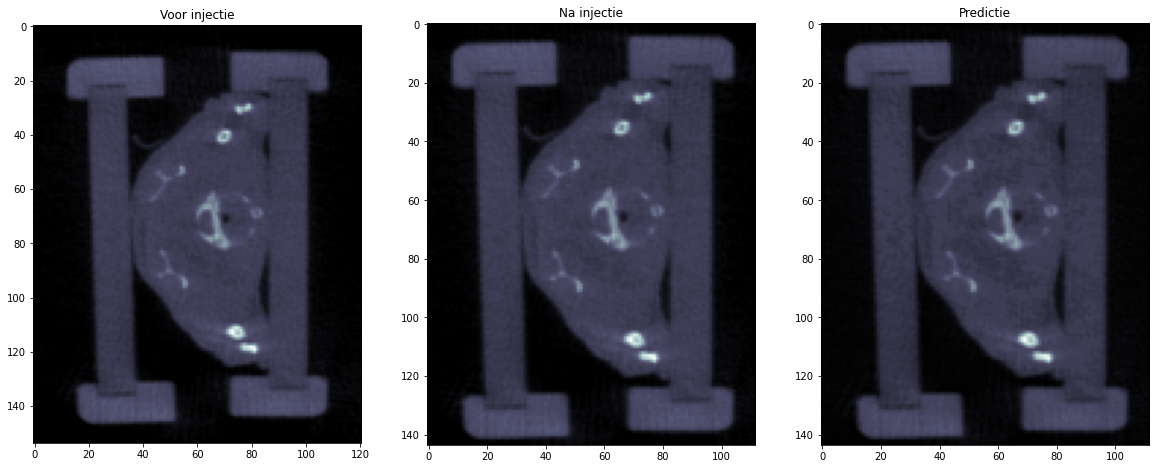

  1%|          | 1/151 [00:01<03:03,  1.22s/it]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  1%|▏         | 2/151 [00:01<01:59,  1.24it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  2%|▏         | 3/151 [00:02<01:38,  1.50it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  3%|▎         | 4/151 [00:02<01:29,  1.65it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  3%|▎         | 5/151 [00:03<01:24,  1.74it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  4%|▍         | 6/151 [00:03<01:20,  1.80it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  5%|▍         | 7/151 [00:04<01:18,  1.83it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  5%|▌         | 8/151 [00:04<01:16,  1.87it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  6%|▌         | 9/151 [00:05<01:15,  1.89it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  7%|▋         | 10/151 [00:05<01:13,  1.91it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


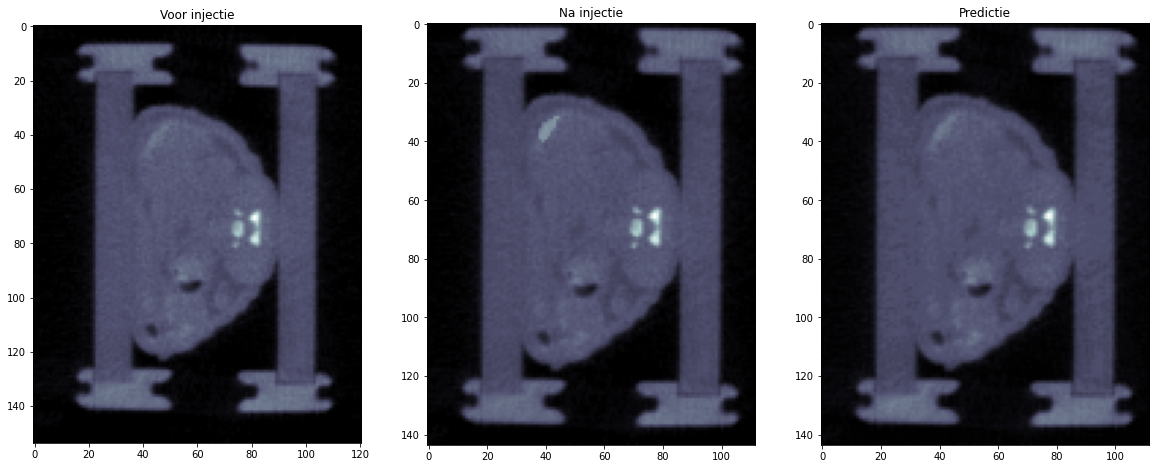

  7%|▋         | 11/151 [00:06<01:31,  1.53it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  8%|▊         | 12/151 [00:07<01:25,  1.63it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  9%|▊         | 13/151 [00:07<01:20,  1.72it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


  9%|▉         | 14/151 [00:08<01:16,  1.79it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


 10%|▉         | 15/151 [00:08<01:14,  1.82it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


 11%|█         | 16/151 [00:09<01:13,  1.85it/s]

gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt
gelukt


 11%|█         | 16/151 [00:09<01:23,  1.62it/s]


KeyboardInterrupt: 

In [50]:
## TRAINING

def MSE(input,output):
    return np.mean((input.detach().cpu().numpy()-output.detach().cpu().numpy())**2)

MSE_voor_na = []
MSE_pred_na = []


for epoch in range(num_epochs):  # we itereren meerdere malen over de data tot convergence?
    print("epoch: {}".format(epoch))
    model.train()
    epoch_loss = 0.0

    for i, (batch_voor, batch_na) in enumerate(tqdm(train_loader)): #wat is een handige manier om dit in te lezen?
        #dim = batch_voor.shape #nu kunnen we ook verschillende input dimensies afhandelen
        
        
        #batch_voor = batch_voor.view(batch_size,1,dim[1],dim[2])
        #batch_na = batch_na.view(batch_size,1,dim[1],dim[2])
        
        if torch.cuda.is_available():
            batch_voor=Variable(batch_voor.cuda())
            batch_na=Variable(batch_na.cuda())
        optimizer.zero_grad()
        predicted_batch = model(batch_voor)
        _, _, H, W = predicted_batch.shape
        batch_na = torchvision.transforms.CenterCrop([H,W])(batch_na)

        afb_pred = predicted_batch[0][0].cpu()
        afb_voor = batch_voor[0][0].cpu()
        afb_na = batch_na[0][0].cpu()
        
        loss = loss_function(predicted_batch,batch_na) #vergelijk predicted na image met de echte na image
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i%10==0: #efjes afgezet
            plt.figure(figsize=(20,10))
            plt.subplot(1,3,1)
            plt.imshow(afb_voor.detach().cpu().numpy(),cmap='bone')
            plt.title('Voor injectie')
            plt.subplot(1,3,2)
            plt.imshow(afb_na.detach().numpy(),cmap='bone')
            plt.title('Na injectie')
            plt.subplot(1,3,3)
            plt.imshow(afb_pred.detach().numpy(),cmap='bone')
            plt.title('Predictie')
            plt.show()
        batch_voor = torchvision.transforms.CenterCrop([H,W])(batch_voor)
        MSE_pred_na.append(MSE(batch_na[0][0],predicted_batch[0][0]))
        MSE_voor_na.append(MSE(batch_na[0][0],batch_voor[0][0]))

#plt.title('Losses')
#plt.plot(losses)
#plt.show()

    #print('Average loss:' + str(epoch_loss/len(train_loader)))

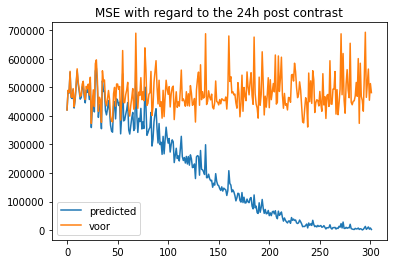

In [ ]:
plt.plot(MSE_pred_na,label = 'predicted')
plt.plot(MSE_voor_na,label = 'voor')
plt.title("MSE with regard to the 24h post contrast")
plt.legend()
plt.show()



In [ ]:
### MODEL OPSLAAN EN OPNIEUW LADEN
#Doe dit om memory te besparen en de GPU te clearen
model_path = "model_TEST.pth"
torch.save(model.state_dict(),model_path)

In [ ]:
torch.cuda.empty_cache()
model = UNet().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
### TESTING
model.eval()
test_acc = []
for i, (batch_voor,batch_na) in enumerate(tqdm(test_loader)):
    #batch_voor = batch_voor.view(batch_size,1,121,242)
    #batch_na = batch_na.view(batch_size,1,121,242)
    
    if torch.cuda.is_available():
        batch_voor=Variable(batch_voor.cuda())
        batch_na=Variable(batch_na.cuda())
    
    predicted_batch = model(batch_voor)

    _, _, H, W = predicted_batch.shape
    batch_na = torchvision.transforms.CenterCrop([H,W])(batch_na)

    loss = loss_function(predicted_batch,batch_na) #vergelijk predicted na image met de echte na image
    test_acc.append(loss)
    if i%10==0:
        print('Step: '+ str(i)+'loss: '+str(loss))
av_test_acc = np.mean(np.array(test_acc))
print(av_test_acc)

  5%|▌         | 3/60 [00:00<00:05, 10.82it/s]

Step: 0loss: tensor(3607.8333, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 4/60 [00:00<00:07,  7.78it/s]


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 4.00 GiB total capacity; 2.85 GiB already allocated; 0 bytes free; 2.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF